# Prepare 1000 Genome Reference dataset with full data
WARNING: NEEDS 60GB OF RAM

UPDATED September 21 to include saving of the X chromosome

In [46]:
import allel
import h5py  # Python Package to do the HDF5.
import numpy as np
import pandas as pd
import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.pyplot as plt

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)
#sys.path.append("./Python3/")  # Since now we are in the Root Directory

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

sys.path.insert(0,"./package/")  # hack to get local package first in path
from hapsburg.PackagesSupport.h5_python.h5_functions import merge_in_ld_map, save_data_h5

midway2-0006.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Helper Function

In [47]:
def filter_vcf_to_biallelic(in_path, out_path):
    """Filters .vcf File to biallelic SNPs"""
    !bcftools view -Oz -o $out_path -m2 -M2 -v snps $in_path 
    print("Finished BCF tools filtering to biallelic variants.")

def vcf_to_hdf5(in_path, out_path, path_vcf100g=""):
    """Transform Full VCF to full HDF5"""
    allel.vcf_to_hdf5(input=in_path, output=out_path, compression="gzip") 
    # Takes 10 Minutes ####chunk_length=1000000, chunk_width=1, garbage performance
    
def download_1kg(path_source="", path_target=""):
    """cluster: Whether program is run on cluster"""
    tbi_s = path_source + ".tbi"
    tbi_t = path_target + ".tbi"
    
    !scp $path_source $path_target # Only Download the .vcf (not the .tbi)
    !scp $tbi_s $tbi_t             # Download the tbi
    print(f"Transfer complete. To {path_target}")
    
def downsample_af(path_h5, path_save, maf=0.002, batch=1000000):
    """Loads hdf5 at path_h5, and filters to loci >maf.
    Save h5 at path_save. Assumes everything is in standard format"""

    f = h5py.File(path_h5, "r") # Load for Sanity Check. See below!

    ### Calculate the AFs
    k = np.shape(f["calldata/GT"])[0]
    
    idcs = [] # the list of list of idx in each batch
    ### Work in batches
    for i in range(int(k/batch)+1):
        print(f"Doing batch {i}...")
        gt = f["calldata/GT"][i*batch:(i+1)*batch,:,:]  
        assert(np.min(gt)==0) # Sanity Check for old data
        assert(np.max(gt)==1) # Sanity Check for old data
        n = np.shape(gt)[1]*2 # number of haplotypes
        gt = np.sum(gt==0, axis=1)
        gt = np.sum(gt, axis=1)
        p_der = 1 - gt/n
        idx = p_der > maf # Filter
        idcs.append(idx)
        
    idx = np.concatenate(idcs)
    print(f"Downsampling to {np.sum(idx)}/{len(idx)} Markers with MAF >{maf}")

    gt = f["calldata/GT"][:,:,:][idx] # Extract the Ind
    assert(np.min(gt)==0) # Sanity Check for new data
    assert(np.max(gt)==1) # Sanity Check for new data
    
    ref=f["variants/REF"][:][idx]
    if len(np.shape(f["variants/ALT"]))>1:
        alt=f["variants/ALT"][:][idx,0] # only save the first alt allele
    else:
        alt=f["variants/ALT"][:][idx]
        
    pos=f["variants/POS"][:][idx]
    rec=f["variants/MAP"][:][idx]
    samples=f["samples"][:]
    f.close()
    
    print("Saving new HDF...")
    save_data_h5(gt=gt, ad=[],
                 ref=ref, alt=alt,
                 pos=pos, rec=rec,
                 samples=samples,
                 path=path_save,
                 compression='gzip',
                 ad_group=False, gt_type='int8')

### Master Function

In [51]:
def full_prep_h5_full(ch = 4, maf=0.002):
    """Function to run the full preparation of HDF from 1000G VCF. 
    Comment out steps if not needed."""
    ### The Paths
    path_vcf_source = f"/project2/jnovembre/data/external_public/1kg_phase3/haps/ALL.chr{ch}.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
    path_vcf_here = f"./Data/1000Genomes/AutosomeVCF/Full/chr{ch}.vcf.gz"
    path_vcf_filter = f"./Data/1000Genomes/AutosomeVCF/Full/chr{ch}.biallelic.vcf.gz"
    path_h5 = f"./Data/1000Genomes/HDF5/FULLHDF5/chr{ch}.hdf5"
    path_h5_maf = f"./Data/1000Genomes/HDF5/FULLHDF5/maf05_chr{ch}.hdf5"
    path_snp1240k = "./Data/1000Genomes/Markers/MinMyc.snp"
    
    ### The functions of the pipeline
    download_1kg(path_vcf_source, path_vcf_here)  ## Takes about 20 seconds
    filter_vcf_to_biallelic(path_vcf_here, path_vcf_filter) ### Takes about XX seconds
    vcf_to_hdf5(path_vcf_filter, path_h5)            ## Takes about 20 minutes
    merge_in_ld_map(path_h5=path_h5, path_snp1240k=path_snp1240k, chs=[ch,], write_mode="a")  ## Takes about XX seconds, mode a for new LD Map
    downsample_af(path_h5, path_h5_maf, maf=maf)
    
    print(f"Run Finished Successfully!")

# Do the full Run

In [52]:
%%time
for ch in range(20,21):
    full_prep_h5_full(ch = ch, maf=0.05)

Transfer complete. To ./Data/1000Genomes/AutosomeVCF/Full/chr20.vcf.gz
Finished BCF tools filtering to biallelic variants.
Lifting LD Map from eigenstrat to HDF5...
Loaded 1739315 variants.
Loaded 2504 individuals.
Loaded 30377 Chr.20 1240K SNPs.
Intersection 29078 out of 1739315 HDF5 SNPs
Interpolating 1710237 variants.
Finished Chromosome 20.
Adding map to HDF5...
We did it. Finished.
Doing batch 0...
Doing batch 1...
Downsampling to 154419/1739315 Markers with MAF >0.05
Saving new HDF...
Successfully saved 2504 individuals to: ./Data/1000Genomes/HDF5/FULLHDF5/maf02_chr20.hdf5
Run Finished Successfully!
CPU times: user 7min 48s, sys: 22.4 s, total: 8min 11s
Wall time: 15min 44s


# Standalone Code for specific tasks

### Downsample to AF SNPs
Start from already downsampled file (for better gains)

In [7]:
%%time

ch=1
path_h5 = f"./Data/1000Genomes/HDF5/FULLHDF5/maf02_chr{ch}.hdf5"
path_h5_maf = f"./Data/1000Genomes/HDF5/FULLHDF5/maf5_chr{ch}.hdf5"


downsample_af(path_h5, path_h5_maf, maf=maf)

Doing batch 0...
Doing batch 1...
Downsampling to 639105/1840756 Markers with MAF >0.05
Saving new HDF...
Successfully saved 2504 individuals to: ./Data/1000Genomes/HDF5/FULLHDF5/maf5_chr1.hdf5
CPU times: user 5min 19s, sys: 15.9 s, total: 5min 35s
Wall time: 5min 36s


In [8]:
for ch in range(2,23):
    path_h5 = f"./Data/1000Genomes/HDF5/FULLHDF5/maf02_chr{ch}.hdf5"
    path_h5_maf = f"./Data/1000Genomes/HDF5/FULLHDF5/maf5_chr{ch}.hdf5"

    print(f"Running Chromosome {ch}")
    downsample_af(path_h5, path_h5_maf, maf=0.05)

Running Chromosome 2
Doing batch 0...
Doing batch 1...
Downsampling to 678281/1978023 Markers with MAF >0.05
Saving new HDF...
Successfully saved 2504 individuals to: ./Data/1000Genomes/HDF5/FULLHDF5/maf5_chr2.hdf5
Running Chromosome 3
Doing batch 0...
Doing batch 1...
Downsampling to 584832/1660264 Markers with MAF >0.05
Saving new HDF...
Successfully saved 2504 individuals to: ./Data/1000Genomes/HDF5/FULLHDF5/maf5_chr3.hdf5
Running Chromosome 4
Doing batch 0...
Doing batch 1...
Downsampling to 605578/1690781 Markers with MAF >0.05
Saving new HDF...
Successfully saved 2504 individuals to: ./Data/1000Genomes/HDF5/FULLHDF5/maf5_chr4.hdf5
Running Chromosome 5
Doing batch 0...
Doing batch 1...
Downsampling to 509422/1500704 Markers with MAF >0.05
Saving new HDF...
Successfully saved 2504 individuals to: ./Data/1000Genomes/HDF5/FULLHDF5/maf5_chr5.hdf5
Running Chromosome 6
Doing batch 0...
Doing batch 1...
Downsampling to 547121/1505863 Markers with MAF >0.05
Saving new HDF...
Successfully 

# Area 51

In [2]:
### Test the Final HDF5 just created
ch = 3
path_load = f"./Simulated/1000G_Mosaic/TSI5/ch3_0cm/data.h5"

f = h5py.File(path_load, "r") # Load for Sanity Check. See below!
print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

Loaded 77652 variants
Loaded 100 individuals
['AD', 'GT']
['ALT', 'MAP', 'POS', 'REF']


In [6]:
f["samples"][:].astype("str")=="iid0"

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

# Test loading the new hdf5 file

In [71]:
ch=21
path_h5_maf = f"./Data/1000Genomes/HDF5/FULLHDF5/maf5_chr{ch}.hdf5"
#path_h5_maf = f"./Data/1000Genomes/HDF5/FULLHDF5/maf5_chr{ch}.hdf5"

In [77]:
### Test the Final HDF5 just created

f = h5py.File(path_h5_maf, "r") # Load for Sanity Check. See below!
print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

Loaded 100164 variants
Loaded 2504 individuals
['GT']
['ALT', 'MAP', 'POS', 'REF']


In [80]:
gt = f["calldata/GT"]

In [81]:
np.max(gt[:,:,:])

1

In [82]:
np.min(gt[:,:,:])

0

# Do experiments about loading time of data

In [52]:
from time import time

In [ ]:
%%time
res = []
s = np.shape(f["calldata/GT"])
ts = [10,50,100,500,1000, 5000, 10000, 50000, 100000]

for i in ts:
    print(f"Doing {i} Loci")
    t = time() 
    idx = np.random.choice(s[0], size=i, replace=False)
    idx=  np.sort(idx)
    gt = f["calldata/GT"][idx,:,:]
    e = time()
    res.append(e-t)

# Allele Frequency Spectrum

In [73]:
%%time
gt = f["calldata/GT"][:,:,:]
gt1 = np.sum(gt==0, axis=1)
gt2 = np.sum(gt1, axis=1)
p_der = 1 - gt2/(np.shape(gt)[1]*2)

CPU times: user 8.89 s, sys: 559 ms, total: 9.45 s
Wall time: 9.69 s


In [74]:
np.mean(p_der < 0.055)

0.02882273072161655

In [75]:
f.close()

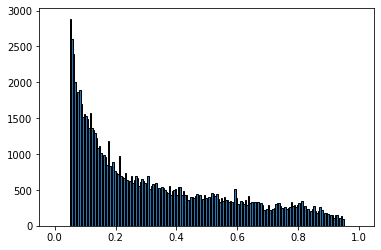

In [76]:
bins = np.linspace(0,1,201)

plt.figure()
ax = plt.gca()
ax.hist(p_der, ec="k", bins=bins)
plt.show()

In [15]:
np.mean(p_der < 0.002)

0.69748

In [45]:
f.close()

### Plot the runtime curve for loading time of #random SNPs

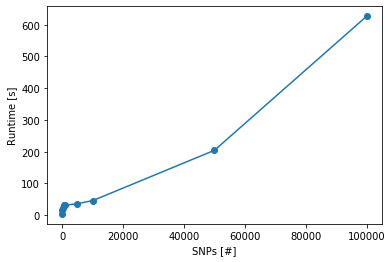

In [65]:
plt.figure()
ax = plt.gca()
ax.plot(ts, res, "o-")
ax.set_xlabel("SNPs [#]")
ax.set_ylabel("Runtime [s]")
plt.show()

In [38]:
gt = f["calldata/GT"][idx,:,:]

(100, 2504, 2)

In [72]:
%%time
gt = f["calldata/GT"][:,:,:]

CPU times: user 1min 2s, sys: 13.1 s, total: 1min 15s
Wall time: 1min 15s


In [10]:
gt[0].dtype

dtype('int8')

In [ ]:
print(f"Doing {i} Loci")

In [2]:
import psutil
print(psutil.virtual_memory().used / (1024.0 ** 3))
print(psutil.virtual_memory().total / (1024.0 ** 3))

5.535064697265625
62.49126052856445


### Try loading 1e6 genotypes - check how much data is needed

In [8]:
a = 1

In [9]:
print(psutil.virtual_memory().used / (1024.0 ** 3))
print(psutil.virtual_memory().total / (1024.0 ** 3))

5.534832000732422
62.49126052856445


In [8]:
%%time
gt = f["calldata/GT"][:1000000,:,1]

CPU times: user 19.1 s, sys: 1.26 s, total: 20.4 s
Wall time: 20.4 s


In [14]:
print(psutil.virtual_memory().used / (1024.0 ** 3))
print(psutil.virtual_memory().total / (1024.0 ** 3))

10.221786499023438
62.49126052856445


# The chunked HDF5 [Legacy because too slow]

In [17]:
### Test the Final HDF5 just created
ch = 4
path_load = f"./Data/1000Genomes/HDF5/FULLHDF5/chr{ch}_chunk.hdf5"

f = h5py.File(path_load, "r") # Load for Sanity Check. See below!
print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

Loaded 5732585 variants
Loaded 2504 individuals
['GT']
['ALT', 'CHROM', 'FILTER_PASS', 'ID', 'MAP', 'POS', 'QUAL', 'REF']


# Test Imputed Genetic Map

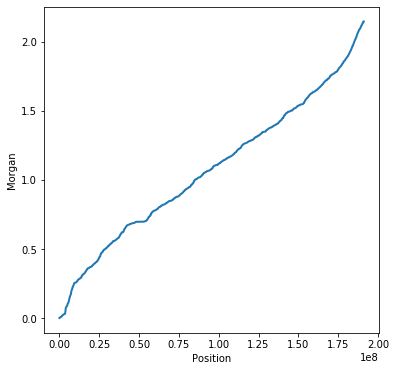

In [14]:
plt.figure(figsize=(6,6))
ax = plt.gca()

ax.plot(f["variants/POS"][:], f["variants/MAP"][:], lw=2)
ax.set_xlabel("Position")
ax.set_ylabel("Morgan")
plt.show()

In [10]:
np.shape(f["calldata/GT"])

(5732585, 2504, 2)

In [7]:
f["calldata/GT"][:100,0,0].

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [11]:
f.close()

## Sandbox

In [ ]:
### Code to change hdf5 gt to int9
%%time

out_folder = "./Data/1000Genomes/HDF5/1240kHDF5/all1240bool0/chr"

def create_int_h5(org_folder = "./Data/1000Genomes/HDF5/FULLHDF5/chr",
                  out_folder = "./Data/1000Genomes/HDF5/FULLHDF5.int8/chr",
                  ch=4):
    """Create a int8 genotype hdf5 from full hdf5"""
    load_path = org_folder + str(ch) + ".h5"
    save_path = out_folder + str(ch) + ".h5" 

    # Make Directory if not already there
    if not os.path.exists(os.path.dirname(save_path)):   
        os.makedirs(os.path.dirname(save_path))

    #os.remove(save_path)  # For previous whoopsie
    m = ModifyHDF5Genotypes(original_path=load_path, save_path=save_path)
    m.downsample_gt(frac=1.0, ad=False, mult_alt=True, gt_type="int8")